<a href="https://colab.research.google.com/github/harisgulzar1/RoadDistressAnalysis/blob/main/Lecture2_1_RoadDistressAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

This tutorial is about fine-tuning the pretrained ResNet50 (CNN Model) for road distress classification.

This tutorial is based on the work **Asphalt Pavement Degradation (APD)**.
The link to the original work is as follows:
https://github.com/inuwamobarak/pavement-degradation-Resnet50/tree/master



---



In [1]:
#magic function for matplotlib graphs. Graphs will be included in notebook next to the code.
%matplotlib inline

In [3]:
#importing dependencies
from __future__ import print_function, division

from datetime import datetime
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy

## Mounting Data from Google Drive
This datasets and resources used for the training are uploaded in the following link.
https://drive.google.com/drive/folders/1bTFHPD-39KifC36kIhaB5-nUmFCsGSM8?usp=sharing

TODO: Create a shortcut of this folder in your google drive.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data
---------


In [4]:
#Dataset from drive
data_dir = "/content/drive/MyDrive/AItraining2data/APD"
train_dataset = "/content/drive/MyDrive/AItraining2data/APD/Train"
val_dataset = "/content/drive/MyDrive/AItraining2data/APD/Validation/"

#Data transformation

In [7]:
#changing the format and structure of the data.
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# The mean and standard daviation of normalization values are based on the pre-training data

data_types = ['Train', 'Validation']

# Loadind the whole data both 'Train' and 'Validation'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in data_types}

# Converting the data into data loader which is tandard format for model to be trained

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in data_types}

# Data sizes for computing accuracy later

dataset_sizes = {x: len(image_datasets[x]) for x in data_types}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Visualization

With the help of data visualization, we can see how the data looks and what we are dealing with from the image.



In [8]:
print("List of Directories:", os.listdir(data_dir))
classes = os.listdir(data_dir + "/Train")
print("List of classes:", classes)

List of Directories: ['Train', 'Validation']
List of classes: ['Fatigue cracks', 'Linear cracks', 'Potholes']


In [9]:
image_size = 300

In [10]:
train_dataset = ImageFolder(data_dir + '/Train', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

val_dataset = ImageFolder(data_dir + '/Validation', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

In [11]:
img, label = val_dataset[2]
print(img.shape, label)

torch.Size([3, 300, 300]) 0


In [12]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Fatigue cracks (0)


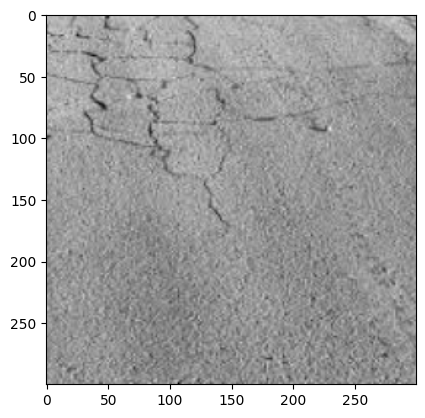

In [13]:
show_example(*train_dataset[56])

#Model Building


Helper function for training the model

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

##Finetuning the Convnet
----------------------
Load a pretrained model and reset final fully connected layer.


In [15]:
#checking for the availability of GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to number of classes.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


## Training and evaluation




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=32)

Epoch 0/31
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.6537 Acc: 0.7400
Validation Loss: 0.5313 Acc: 0.7863

Epoch 1/31
----------


KeyboardInterrupt: 

In [17]:
# Load model weights
model_path = '/content/drive/MyDrive/AItraining2data/model-APD-pytorch-res50-92accuracy.pt'
model_ft = torch.load(model_path)

# Model Accuracy Testing

In [18]:
def check_accuracy(test_loader, model, device):
    num_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device=device)
            labels = labels.to(device=device)

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            num_correct += (predictions == labels).sum()
            total += labels.size(0)
        print(f"Test Accuracy of the model: {float(num_correct)/float(total):.2f}")

check_accuracy(dataloaders['Validation'], model_ft, device)

Test Accuracy of the model: 0.91


In [19]:
import torch
from torchvision import transforms
from PIL import Image

# Define the transformation to be applied to the input image
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize to match the input size of the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to predict the label of a single image
def predict_image(image_path, model, device):
    # Load and transform the image
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)  # Add batch dimension

    # Move image tensor to the correct device
    img = img.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Disable gradients (not necessary for inference)
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(img)
        # Get the predicted class index
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()  # Get the Python number from a tensor containing a single value

    return predicted_class

# Function to show an image
def show_image(image_path, title=None):
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)  # Add batch dimension

    # Convert the tensor to a numpy array and then to CPU
    img = img.cpu().numpy()

    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.squeeze(0)  # Remove the batch dimension
    img = np.transpose(img, (1, 2, 0))  # (C, H, W) to (H, W, C)
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # Display the image
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Turn off axis labels
    plt.show()

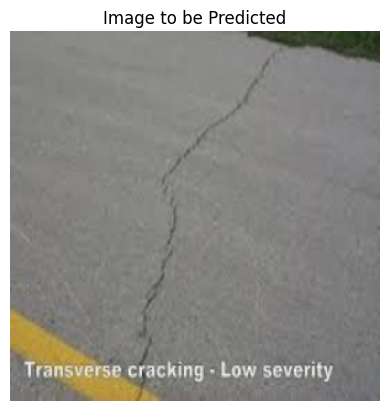

Predicted label: Linear cracks


In [20]:
# Image to be Predicted

image_path = '/content/drive/MyDrive/AItraining2data/APD/Validation/Linear cracks/linear_crack (470).jpg'
show_image(image_path, title='Image to be Predicted')

predicted_label = predict_image(image_path, model_ft, device)
print(f'Predicted label: {classes[predicted_label]}')

## Model Saving

In [ ]:
torch.save(model_ft, 'model-APD-pytorch-res50-92accuracy.pt')